###GOAL: Create a method to iteratively identify all the KOs/COs assocaited with a CO for compounds identified by Krista in the NB study
####Here I am going to employ *beautiful soup* to parse the html websites of the different COs within KEGG to identify the KOs that are associated with a given CO. I have a list of ~100 Compounds identified by Krista. I pulled all the data assocaited with each of those compounds with the hopes of linking the changes in concentrations with changes in relative gene transcript abundance. 

In [1]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal

%matplotlib inline

<img src="Figure1_StackPlot-01.png"style="width: 800px;">
<img src="Figure3_CellHeatmap_Hot-01.png"style="width: 1000px;">

## Summed all the species of phytoplankton based on orthology. 
###Some problems: 
- Dinoflagellates don't regulate their transcriptome: this might mute the signals
- Not including all organisms might raise eyebrows during review.

<img src="Pmi.png">

In [2]:
CO_RawData=pd.read_csv('RImetabolites.2015.06.02.csv', index_col='cNumber')
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
CO_RawData=CO_RawData[CO_RawData.sum(axis=1)!=0]

##Distribution of Data
First-- taking a look at how the raw data is distributed.  I need to run a goodness of fit test-- but it appears that both datasets are similarly distributed (poisson perhaps?)

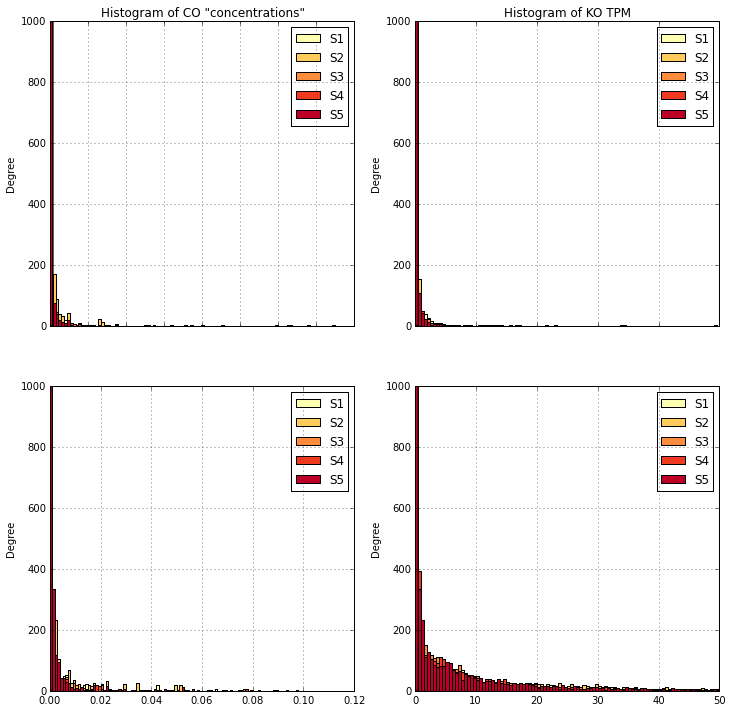

In [3]:

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

It is quite evident that the dataset have very different ranges.  0.000-0.8 and 0-10,000. So, I need to figure out a good way to normalize the data.  I am not totally sure what the best way to do it is, but let's give dividing by the mean a try.  That will wash outthe differences in magnitude. These distributions look similar-- but also suggest that the coverage of the CO data is less (not surprising-- fewer hits etc.)

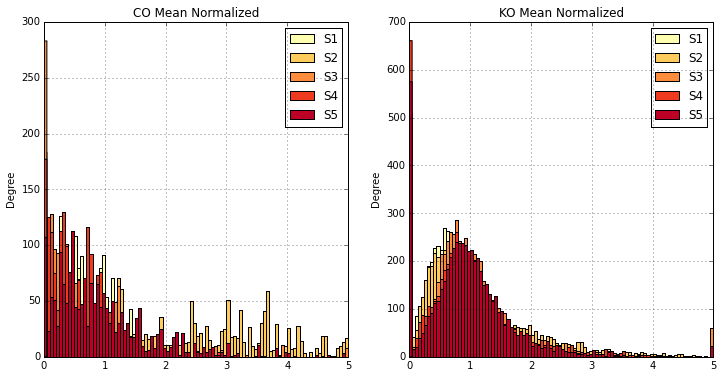

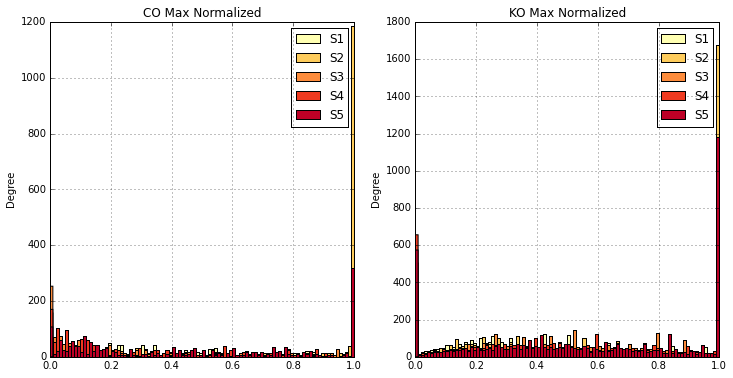

In [4]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out




CO_Norm2Mean=NormalizeToMean(CO_RawData)
KO_Norm2Mean=NormalizeToMean(KO_RawData)
CO_Norm2Max=NormalizeToMax(CO_RawData)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])



Why not compare the two coefficients of variation. Why does it cap off at 2? That is weird. 

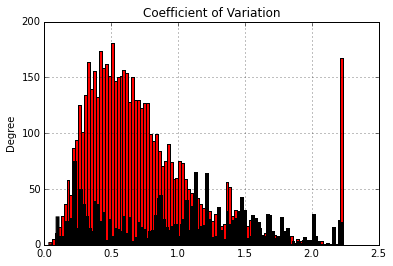

In [5]:

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')


####Check the CO data out and see if anything in particular looks interesting. 
The below script is pitifully slow-- so I think it would take a very long time to process ~1000 COs because it is internet based.  But, it did it.

In [6]:
#Here I was working on getting these data integrated into aprogram; That program was 
#written and saved as CreateHash_COtoKO.py. So, these are obsolete as of 2 June 2015. 


def getROData(RO):
    #get the KO/CO data associated with a reaction
    RO_httpstr='http://www.genome.jp/dbget-bin/www_bget?rn:'
    ROsite=urllib2.urlopen(RO_httpstr+RO)
    Rsoup=BeautifulSoup(ROsite)
    Rtable=Rsoup.table
    KOlist=Rtable.findAll(text=re.compile('K[0-9]{,5}$'))
    KOlist=[str(item) for item in KOlist]
    COlist=Rtable.findAll(text=re.compile('^C[0-9]{,5}$'))
    COlist=[str(item) for item in COlist]

    return KOlist, COlist
    
def getKOfromCO(COid):
    #Function to find and locate pertenant information about the CO (compound) ids
    #Get the website that we want by adding this string to the input
    CO_httpstr='http://www.genome.jp/dbget-bin/www_bget?cpd:'
    CO_httpfull=CO_httpstr+COid
    COsite=urllib2.urlopen(CO_httpfull)
#     Use beautiful soup to parse the website
    Csoup = BeautifulSoup(COsite)
    #Identify the table on the website
    COtable=Csoup.table
    #Find all of the reaction numbers
    ReactionNums=COtable.findAll(text=re.compile('^R[0-9]{,6}$'))
    ReactionNums=[str(item) for item in ReactionNums]

    ModuleNums=COtable.findAll(text=re.compile('^M[0-9]{,6}$'))
    ModuleNums=[str(item) for item in ModuleNums]

    #Open reaction and identify the KO numbers
    ReactionDict={}
    
    for RO in ReactionNums:
        KOlist,COlist=getROData(RO)
        rx={}
        rx['KO']=KOlist
        rx['CO']=COlist
        ReactionDict[RO]=rx
    KO=[v['KO'] for v in ReactionDict.itervalues()]
    CO=[v['CO'] for v in ReactionDict.itervalues()]
    KO_Set=list(set([item for sublist in KO for item in sublist]))
    CO_Set=list(set([item for sublist in CO for item in sublist]))
    return ReactionDict, KO_Set, CO_Set,  ModuleNums



<img src="CO.png">

<img src="Rxn.png">

###Load in the assocaited COs and KOs
The above scripts were used to geterate a series of connections between the KOs and the COs. These data were pickled as a hash and can be loaded



In [7]:
import cPickle as cpk
 
WorkingFile=cpk.load(open('running_Script.pickle', 'r'))



In [8]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an assocaited KO.', len(CO_withoutKO), 'are not associated with a KO.'


There are 353 COs with an assocaited KO. 1442 are not associated with a KO.


In [9]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()



##Plot some interesting correlations

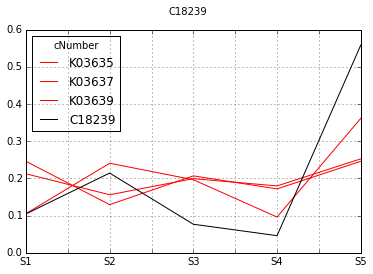

In [14]:

def PlotCompoundsKOs(InterestingCompounds):
    for i, CO in enumerate(InterestingCompounds):
    #     if i==20:
    #         break
        kos=CO_withKO[CO]['Related KO']
        cos=CO_withKO[CO]['Related CO']
        for k in kos: 
            if k in KO_RawData.index: 
                kData=KO_RawData.loc[kos].dropna()
                kData=(kData.T/kData.sum(axis=1)).T
                cData=CO_RawData.loc[cos].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)
                fig.suptitle(CO)
                fig.savefig(CO+'.png')
                break

IC=['C18239']
PlotCompoundsKOs(IC)

###cPMP; Cyclic pyranopterin phosphate; Cyclic pyranopterin monophosphate; Precursor Z;
###molybdopterin synthase sulfur carrier subunit
<img src="R09394.gif">

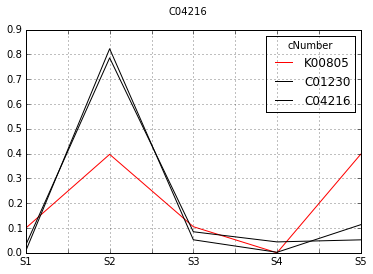

In [17]:
IC=['C04216']
PlotCompoundsKOs(IC)

###all-trans-Heptaprenyl diphosphate
###heptaprenyl diphosphate synthase
<img src="R09394.gif">

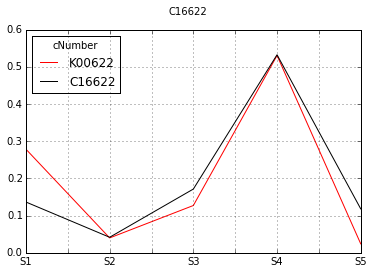

In [19]:
IC=['C16622']

PlotCompoundsKOs(IC)

###Compound = Diacetylhydrazine
###acetyl-CoA:acetylhydrazine N-acetyltransferase

<img src="R08250.gif">

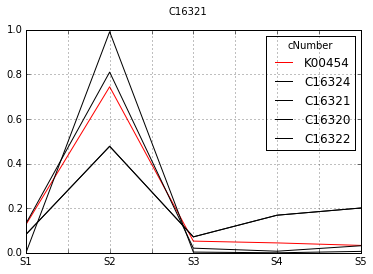

In [21]:
IC=['C16321']
PlotCompoundsKOs(IC)

###Lipoxygenase
<img src="R07864.gif">

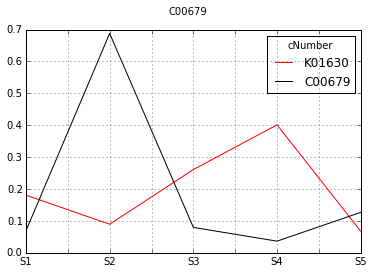

In [54]:
IC=['C00679']
PlotCompoundsKOs(IC)

###2-dehydro-3-deoxyglucarate aldolase
###5-Dehydro-4-deoxy-D-glucarate
<img src="R02754.gif">
<img src="Phaeodactylum.png">


###KMeans Clustering

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

def kmeanCluster(data,nc):
    kmeans=KMeans(n_clusters=nc)
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):

    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
#         ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                     c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Automatically created module for IPython interactive environment


##K-means cluster KO_data

('For n_clusters =', 14, 'The average silhouette_score is :', 0.26820676425158552)


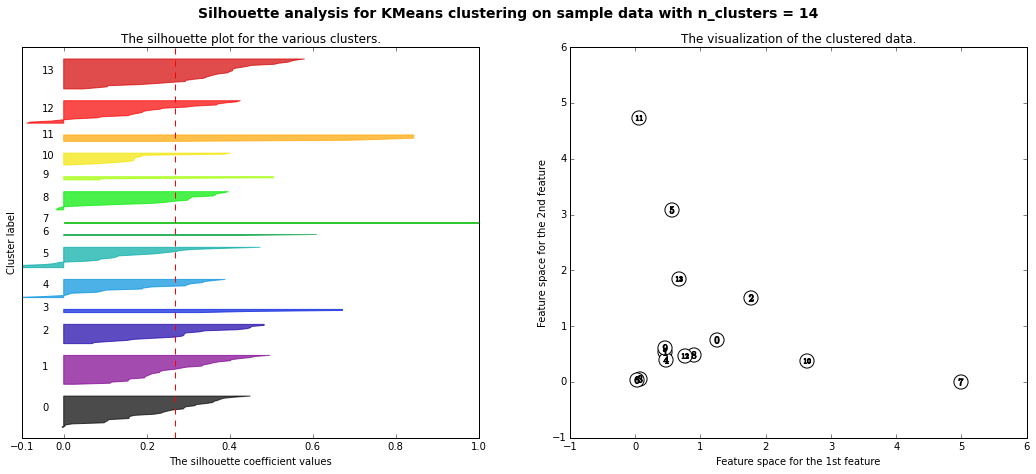

('For n_clusters =', 15, 'The average silhouette_score is :', 0.26669832287119455)


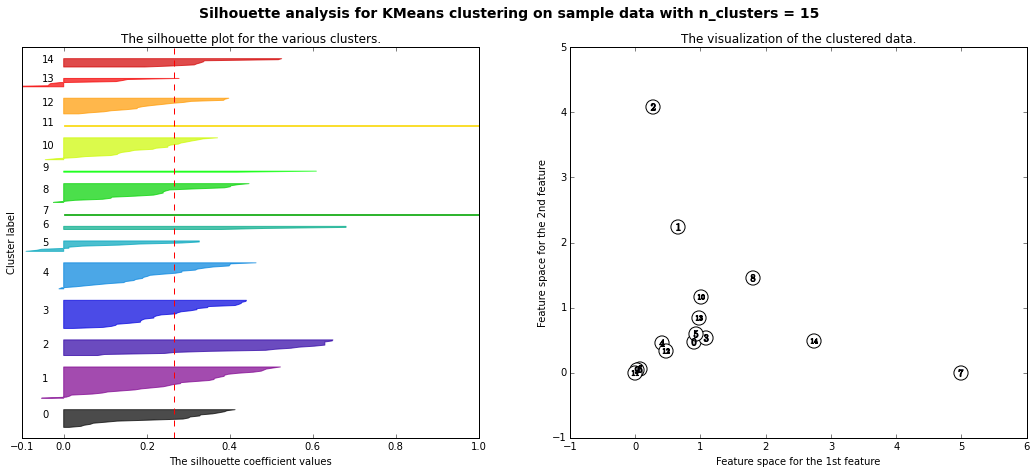

In [23]:
#Silhoette data to determine optimal number of clusters
silhoetteAnalysis(KO_limited_Norm2Mean, np.arange(14,16,1))

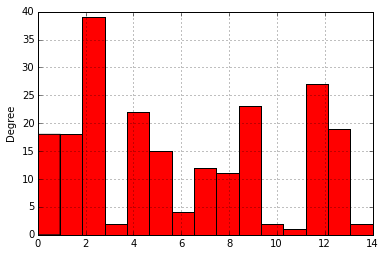

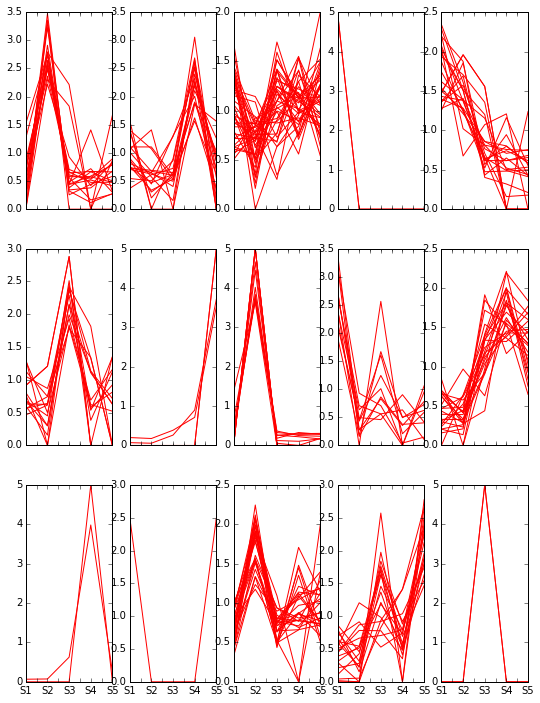

In [24]:
koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
PlotKmeans(koClust,15,3,5, 'r') 

('For n_clusters =', 14, 'The average silhouette_score is :', 0.38238972906901464)


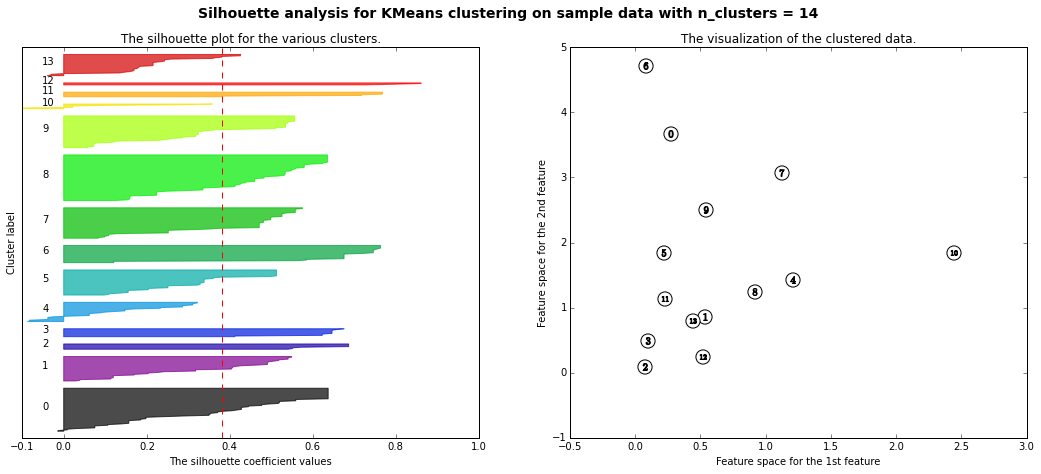

('For n_clusters =', 15, 'The average silhouette_score is :', 0.37655440513788624)


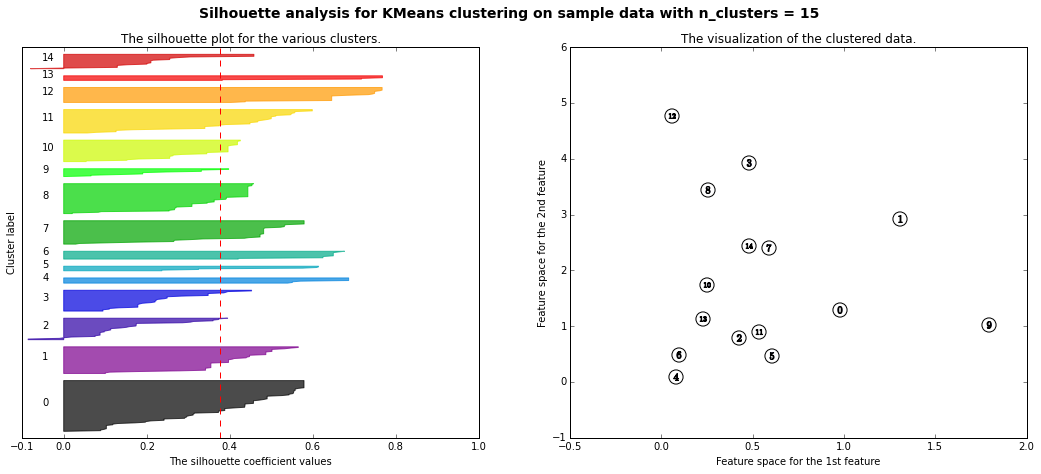

In [26]:
silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(14,16,1))

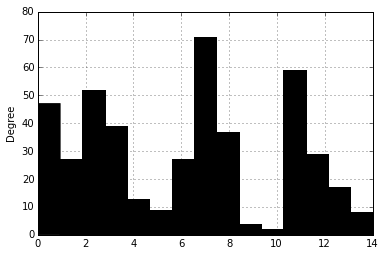

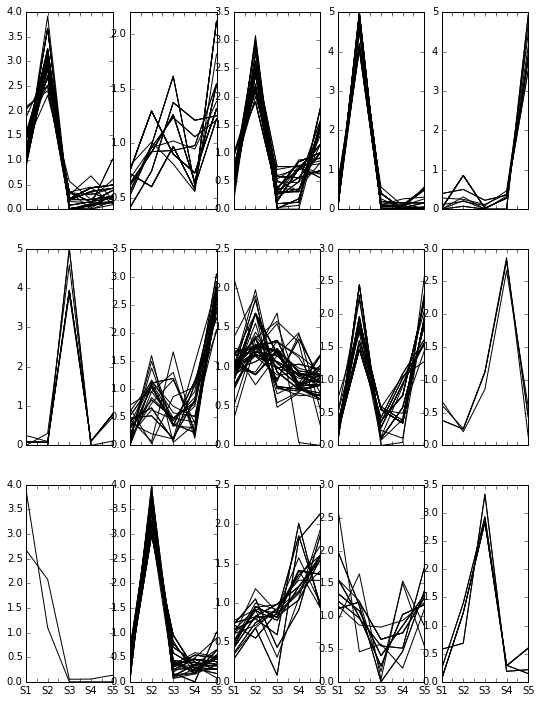

In [27]:
coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
PlotKmeans(coClust,15,3,5, 'k') 

By normalizing the data to the mean we can then (in theory) combine the two and cluster them together? 

('For n_clusters =', 15, 'The average silhouette_score is :', 0.31446042530746265)


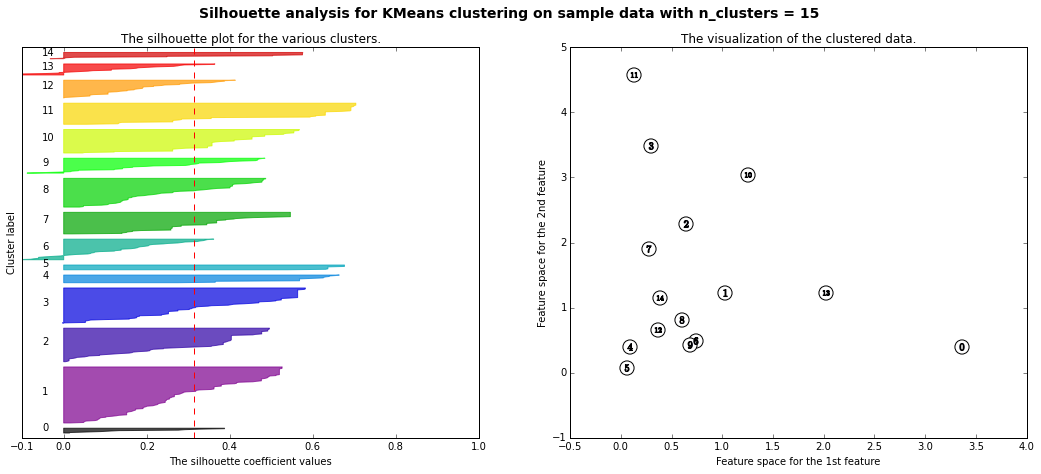

('For n_clusters =', 16, 'The average silhouette_score is :', 0.32224556555584161)


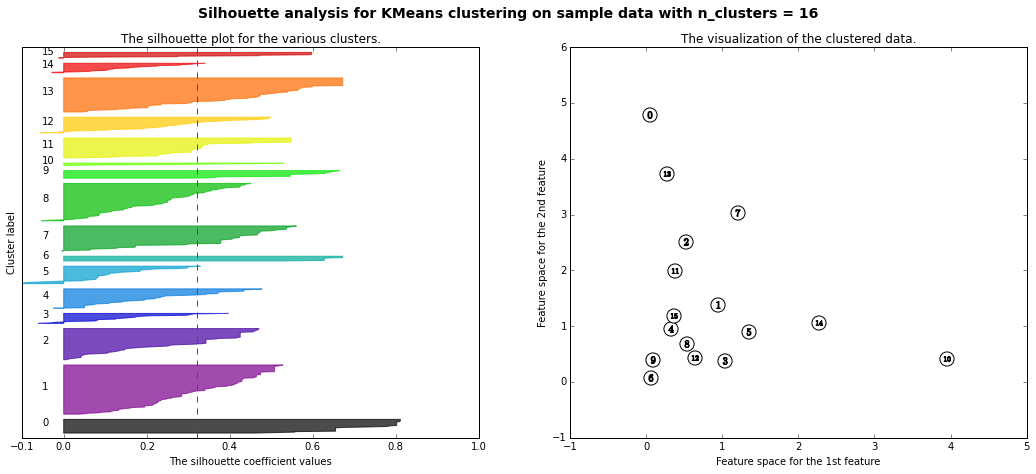

('For n_clusters =', 17, 'The average silhouette_score is :', 0.31557824751953945)


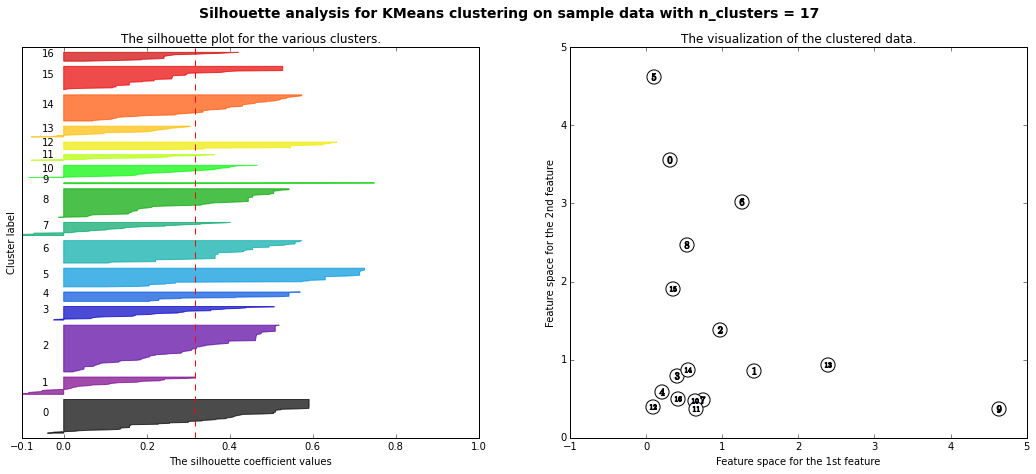

('For n_clusters =', 18, 'The average silhouette_score is :', 0.30935302399530556)


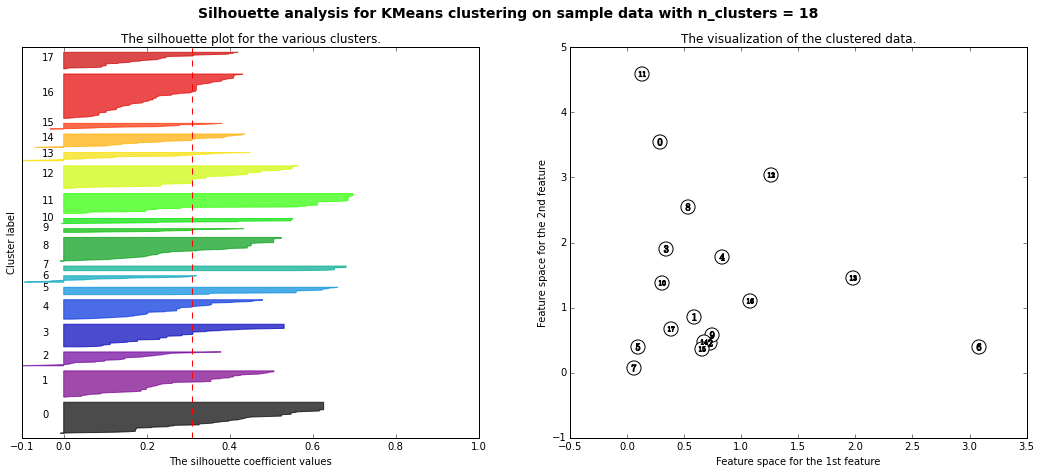

In [32]:
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
# Combined_KO_CO_MeanNorm=Combined_KO_CO_MeanNorm-Combined_KO_CO_MeanNorm.mean()
#Run silhoette analysis
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(15,19,1))

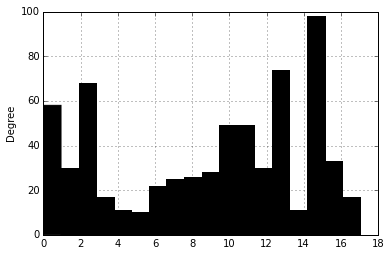

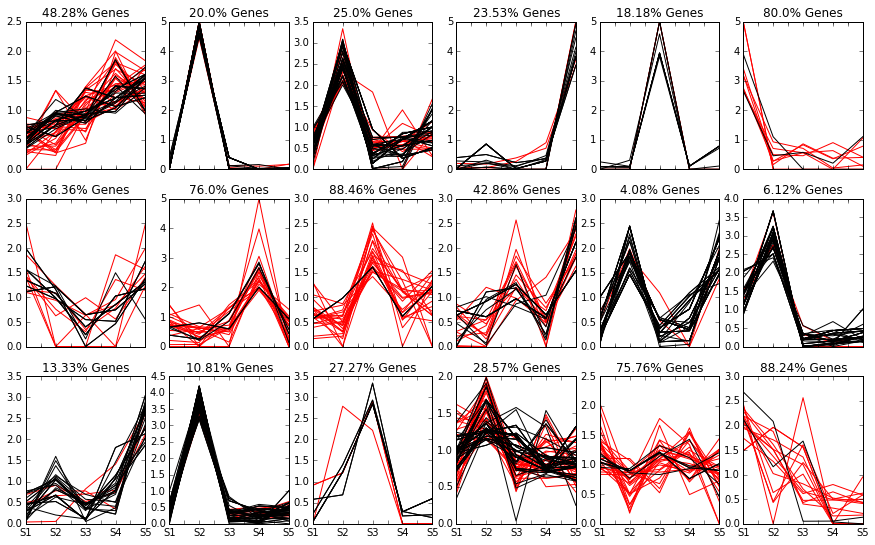

In [33]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    Cs=re.compile('C.*')
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title(str(round(KPct,2))+'% Genes')
    
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, 18)
PlotKmeansCombined(CcoClust,18,3,6, 'r') 


##Dive in and look at some of these clusters more closely: Do clusters contain genes and enzymes that are related to each other functionally? 

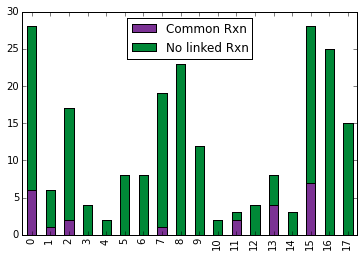

In [53]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        i=kClust.index
        i=list(i)
        Csearc=re.compile('C.*')
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False, title )
    
    
CheckRelatedness(CcoClust, 18)

###Initial thoughts: K means clustering is a good way to find genes assocaited with production/synthesis of a compound but will not find inverse relationships (e.g. catabolism: enzyme that decreases the concentration of a compound )

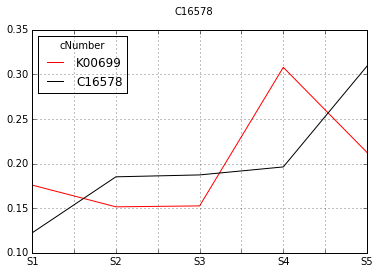

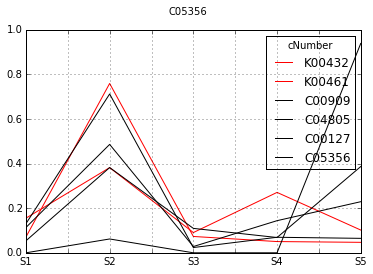

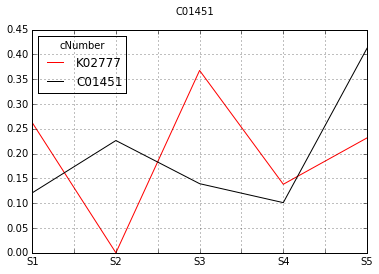

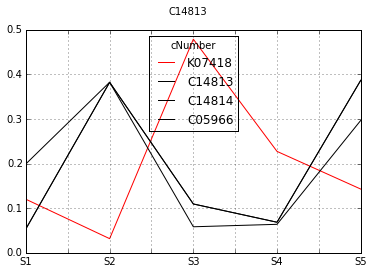

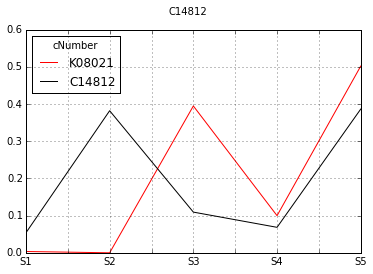

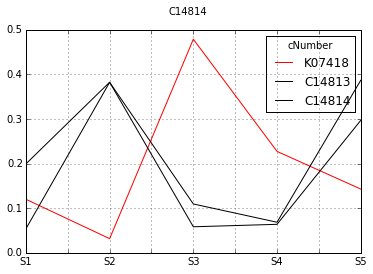

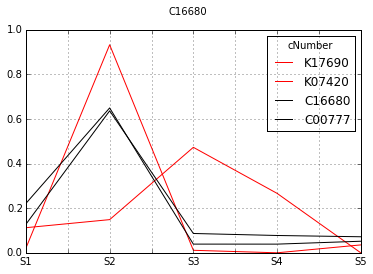

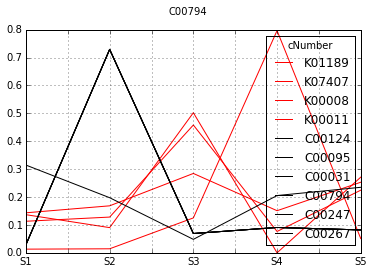

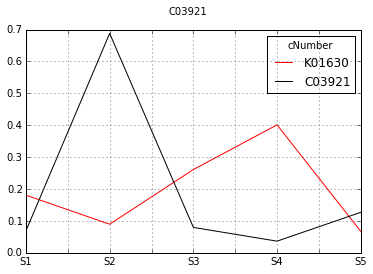

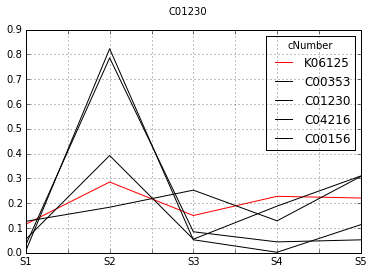

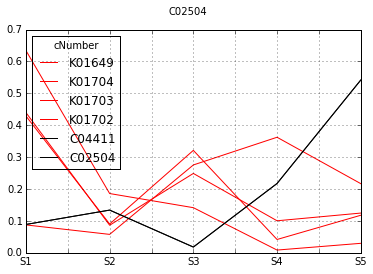

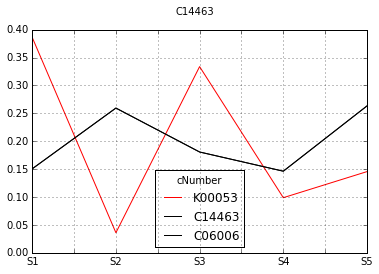

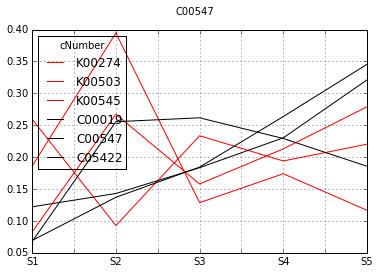

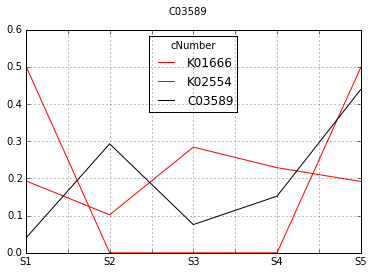

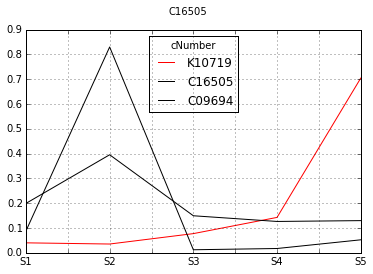

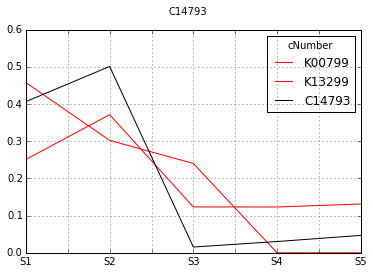

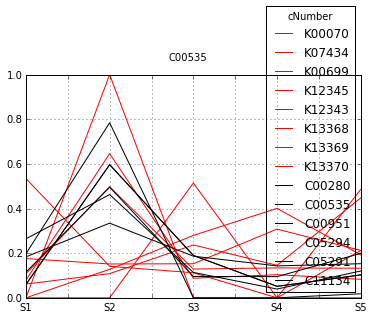

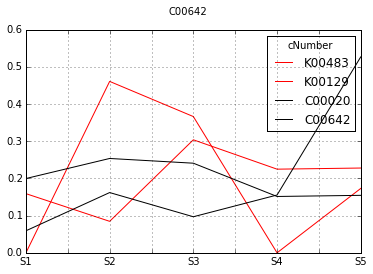

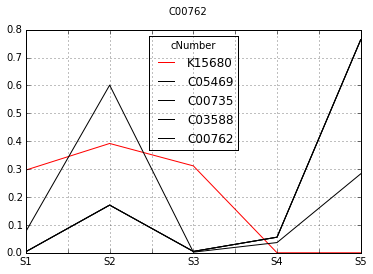

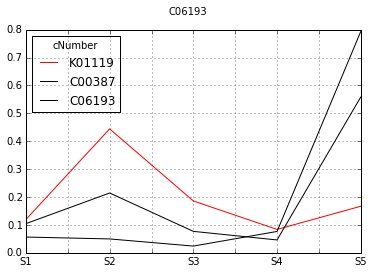

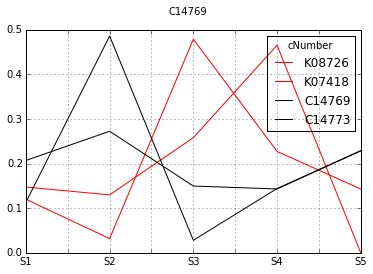

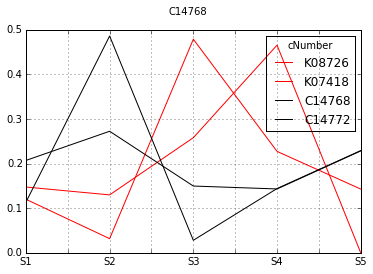

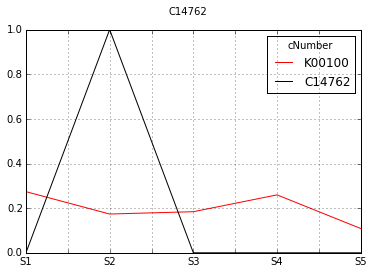

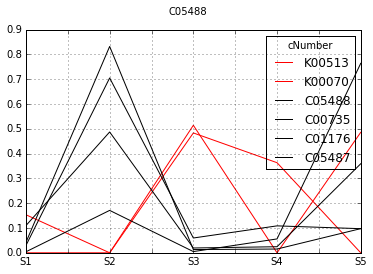

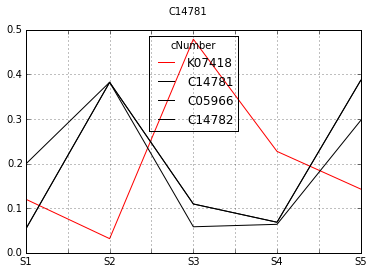

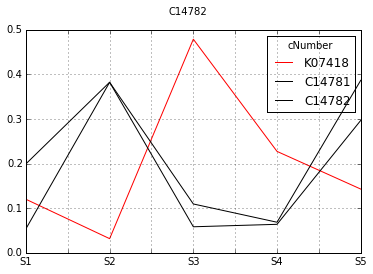

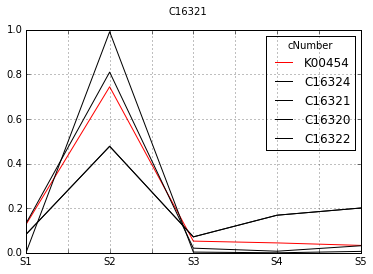

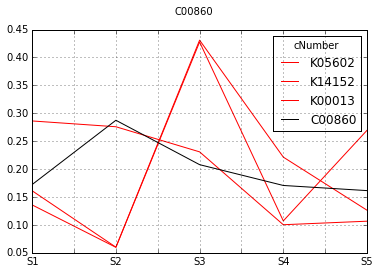

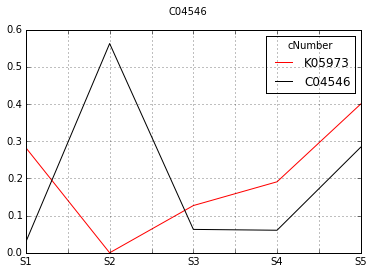

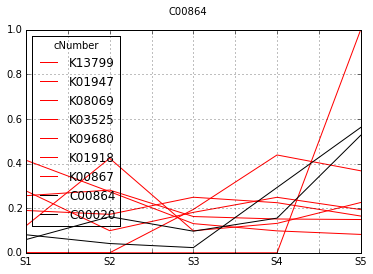

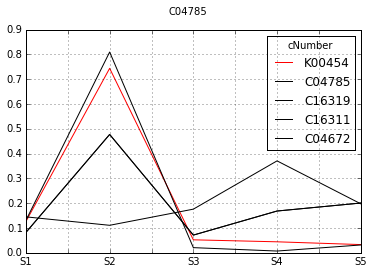

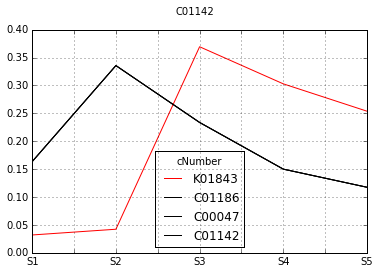

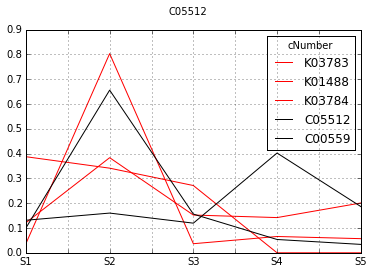

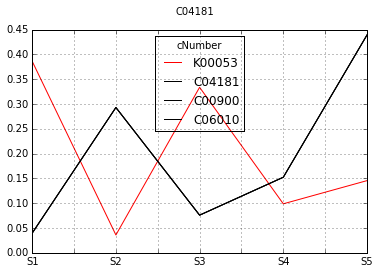

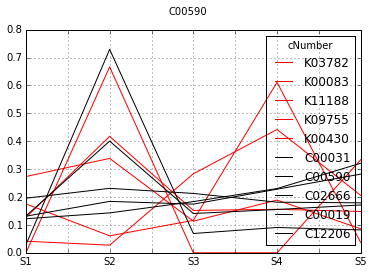

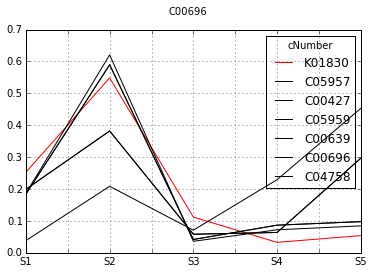

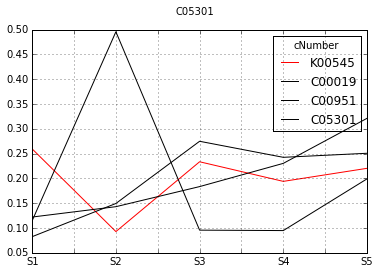

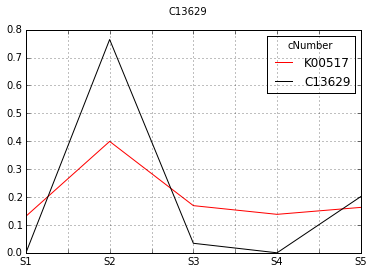

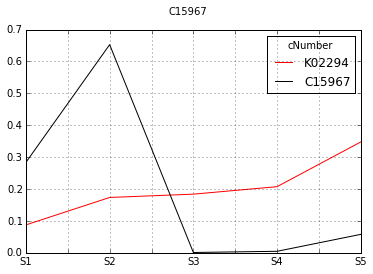

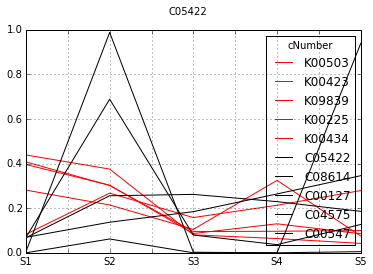

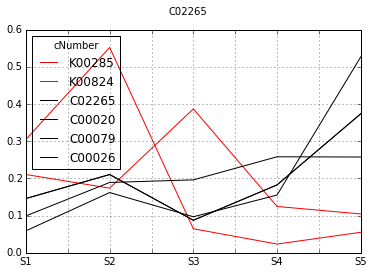

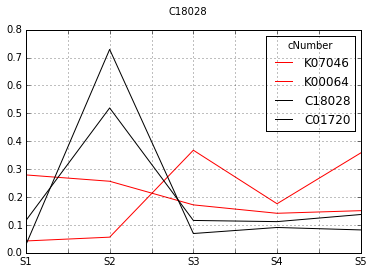

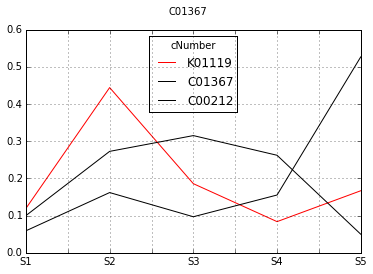

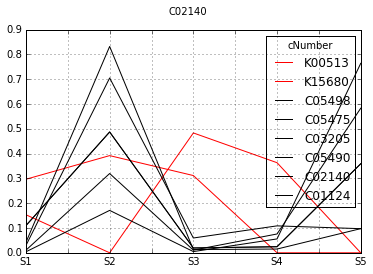

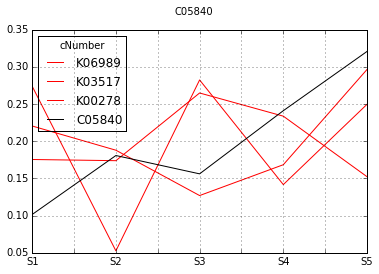

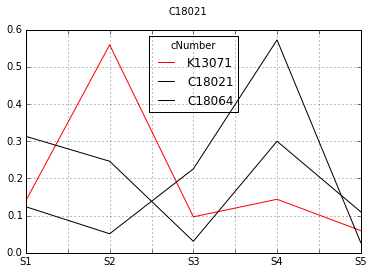

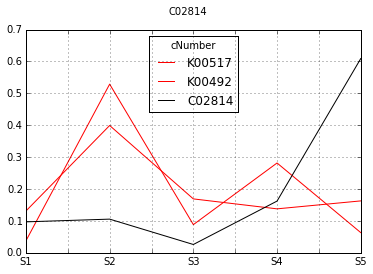

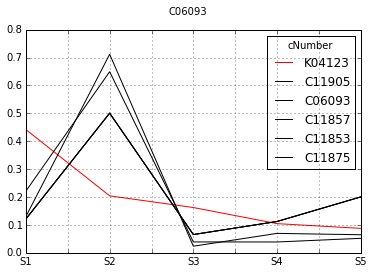

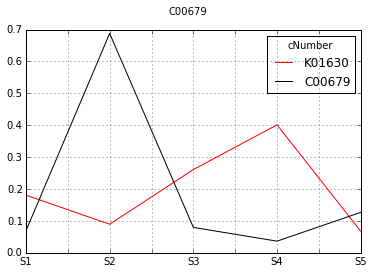

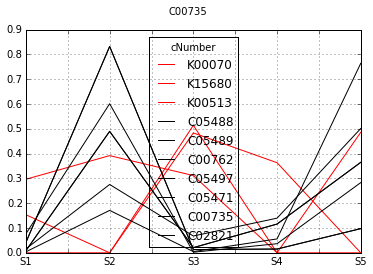

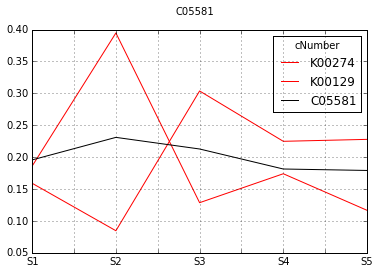

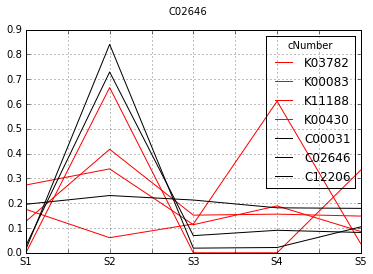

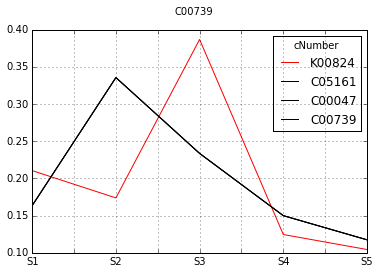

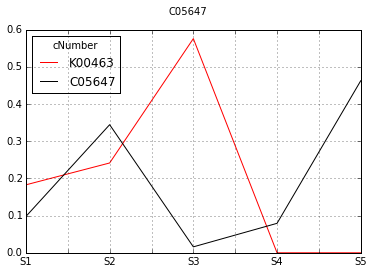

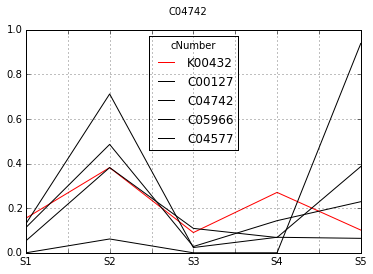

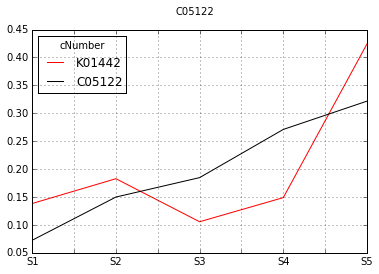

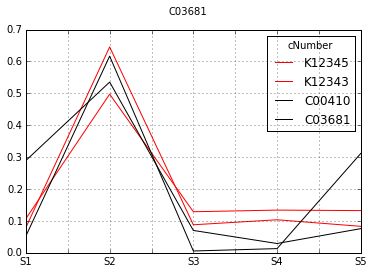

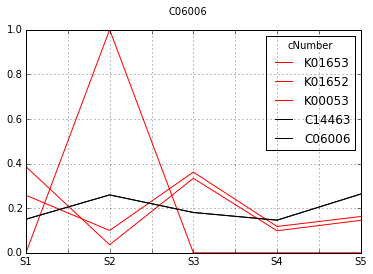

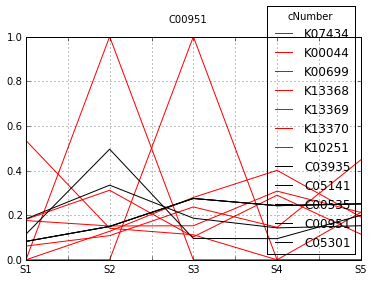

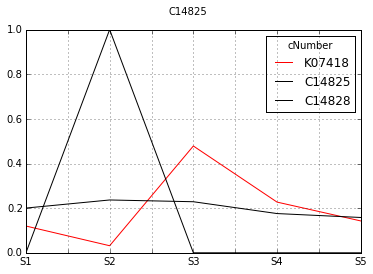

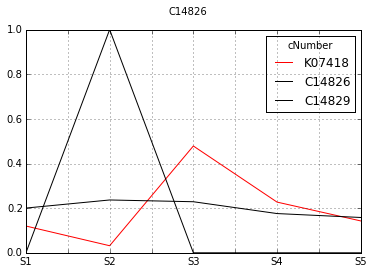

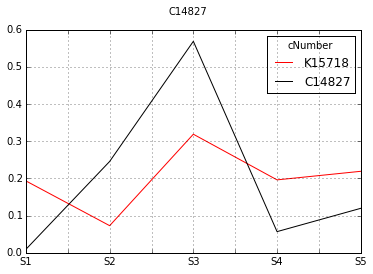

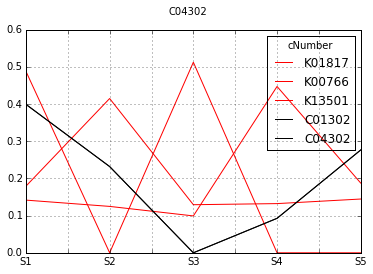

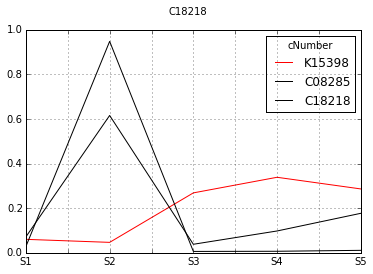

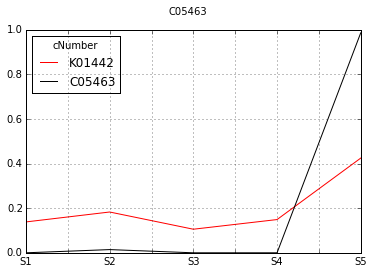

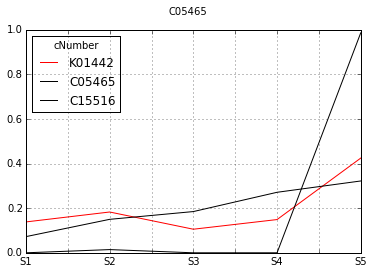

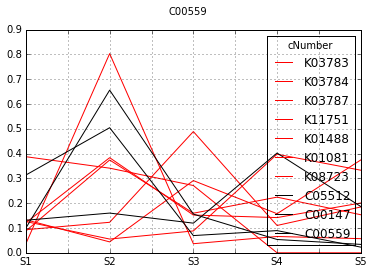

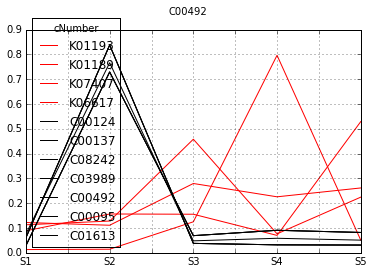

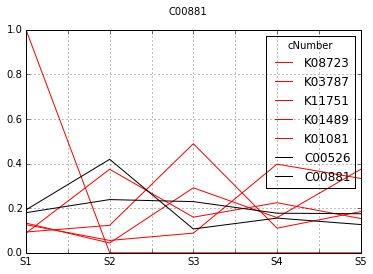

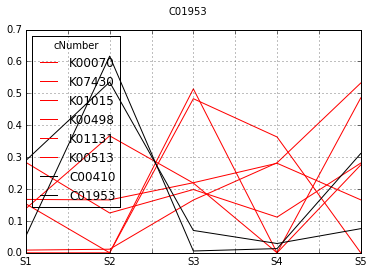

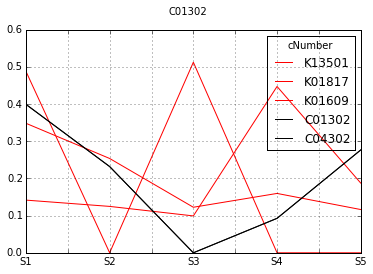

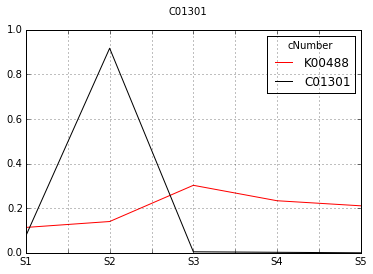

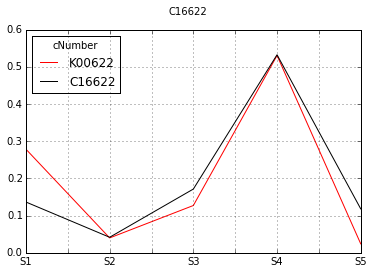

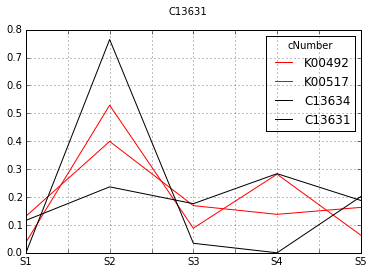

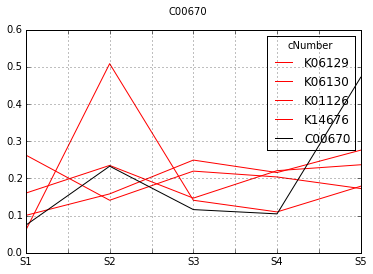

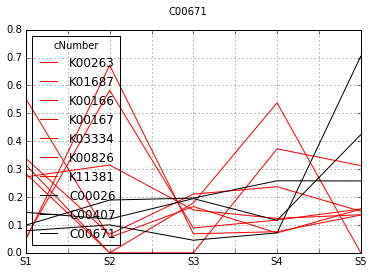

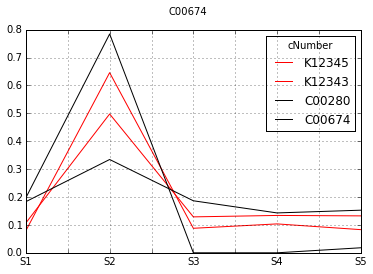

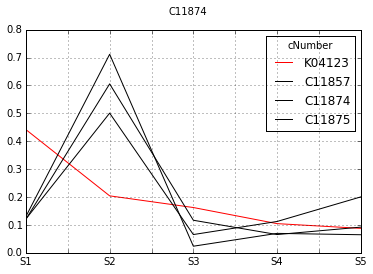

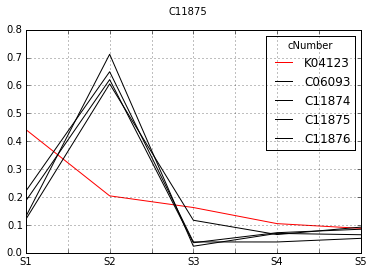

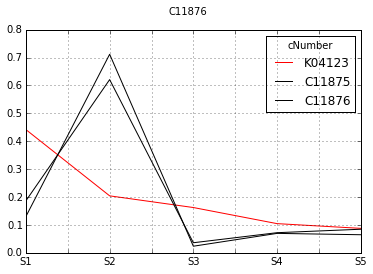

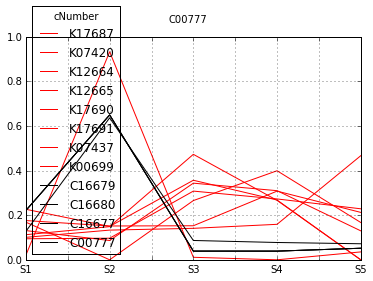

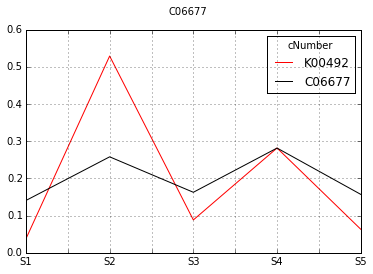

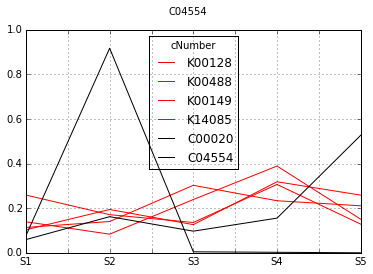

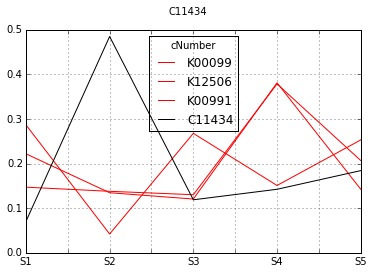

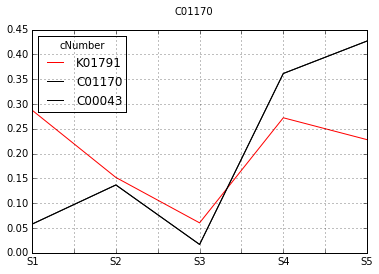

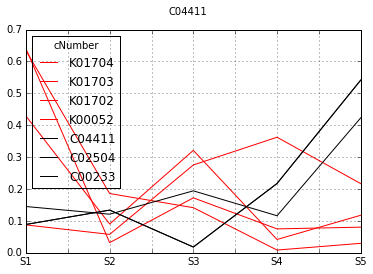

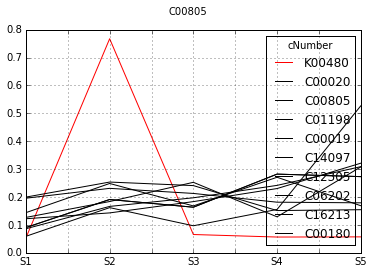

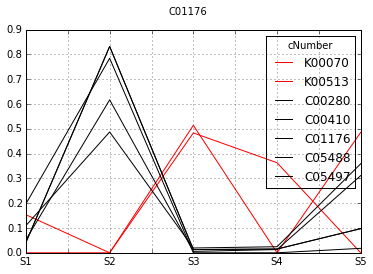

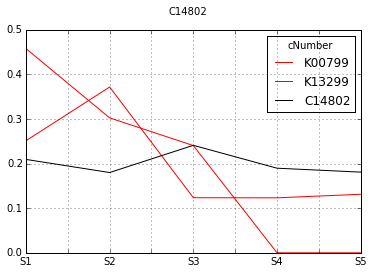

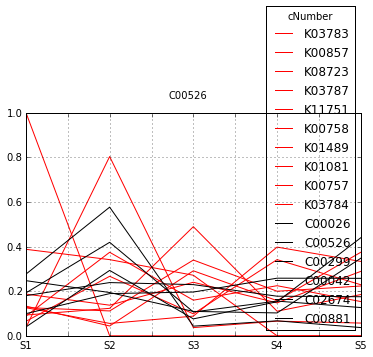

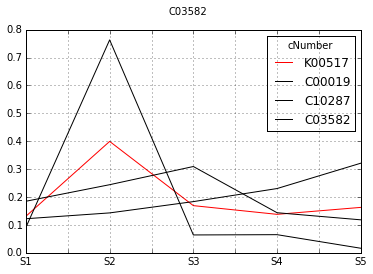

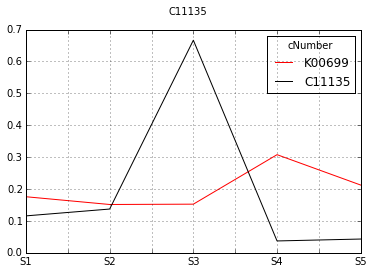

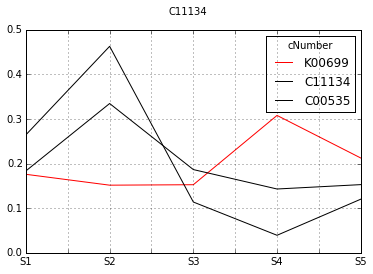

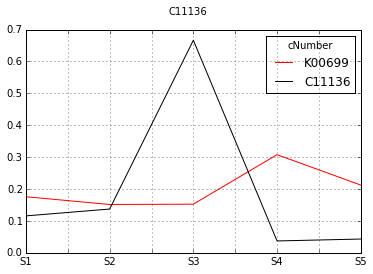

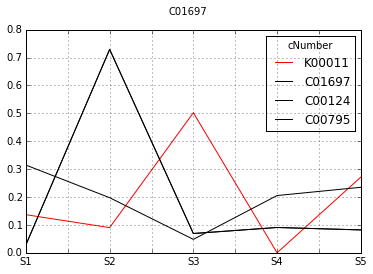

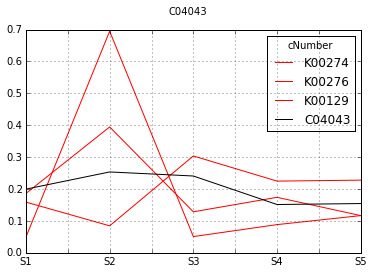

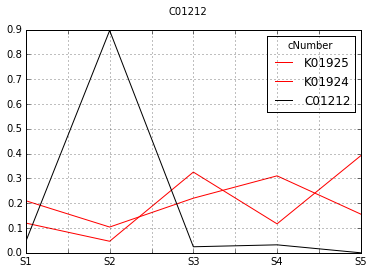

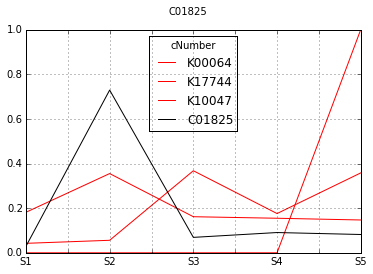

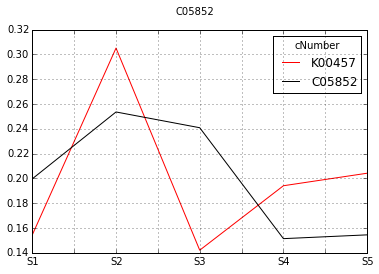

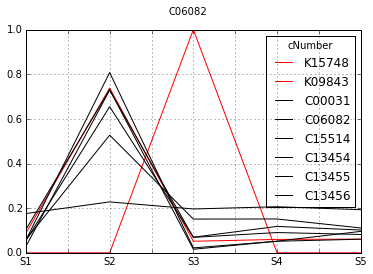

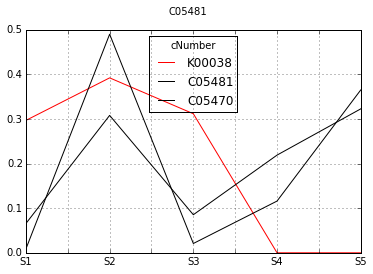

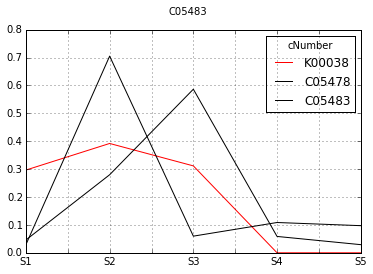

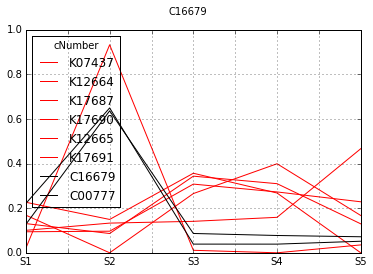

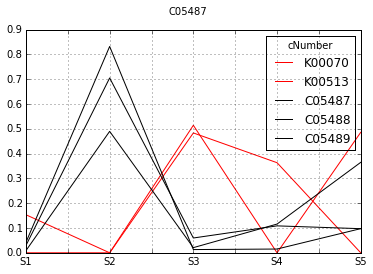

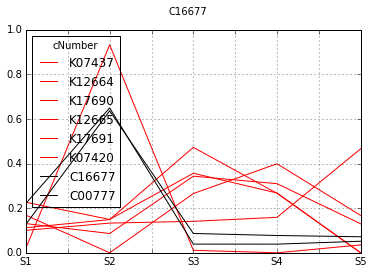

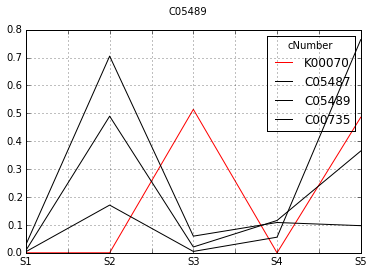

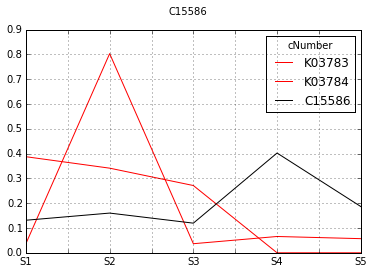

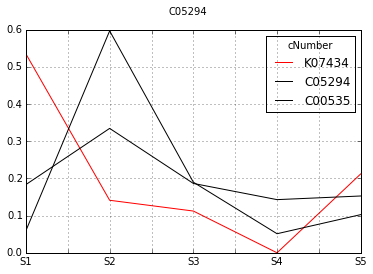

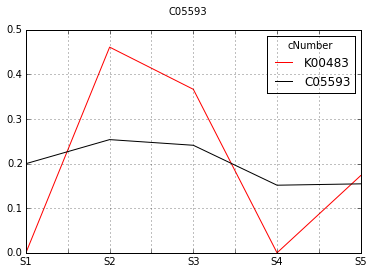

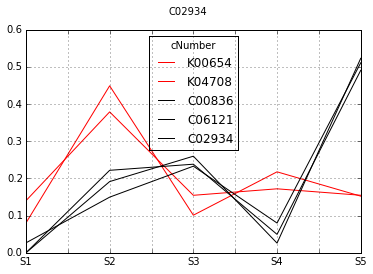

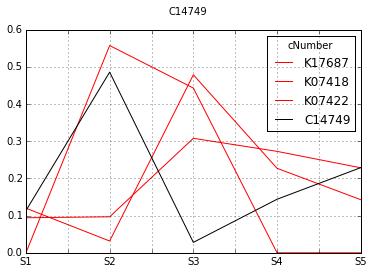

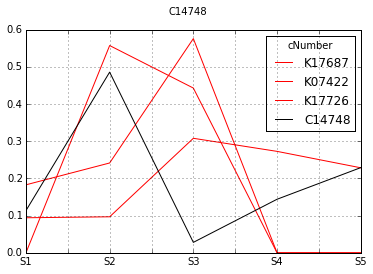

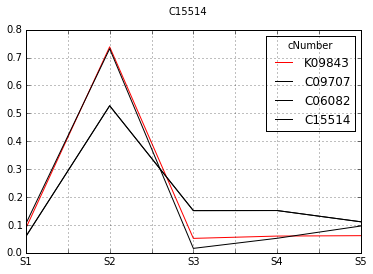

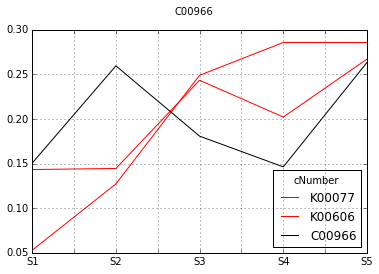

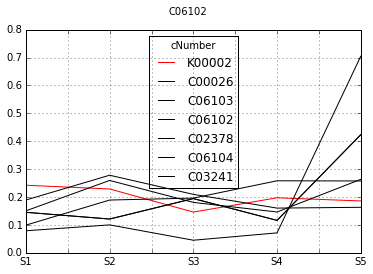

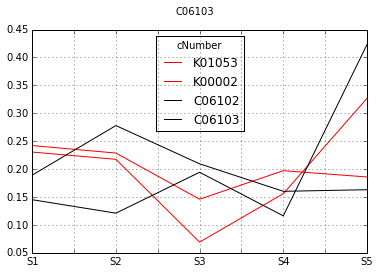

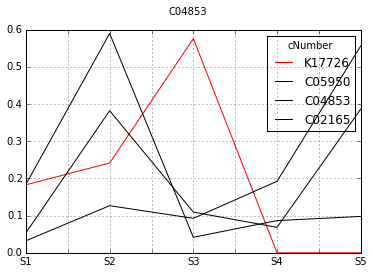

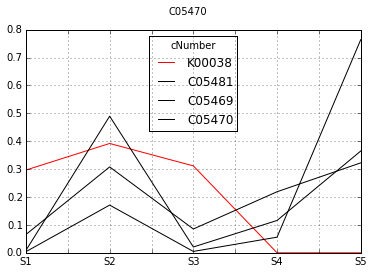

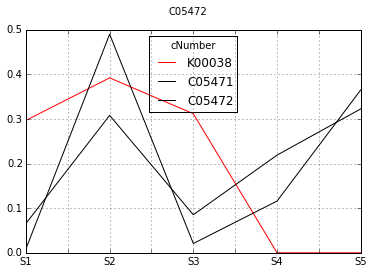

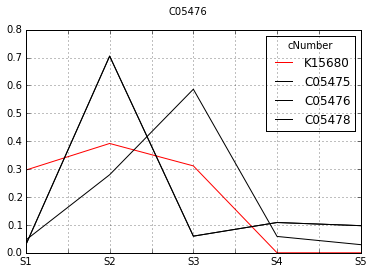

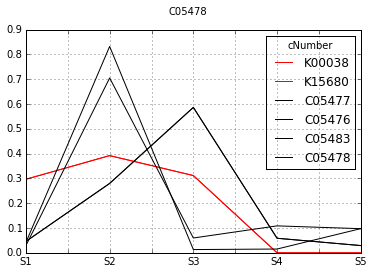

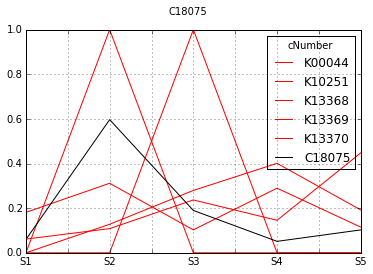

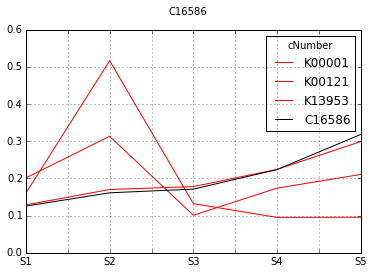

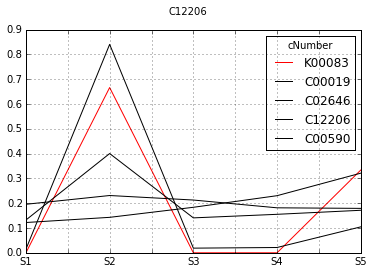

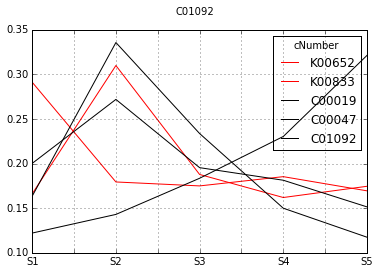

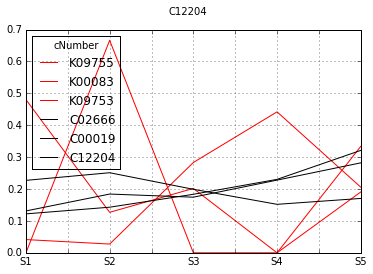

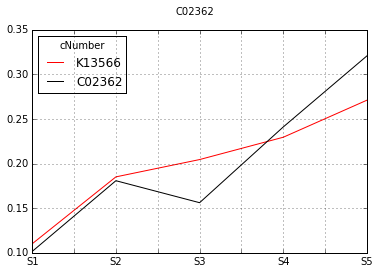

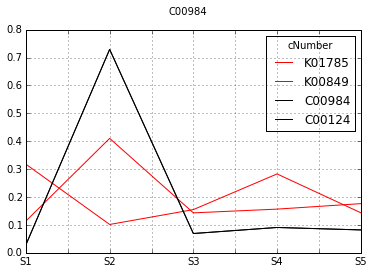

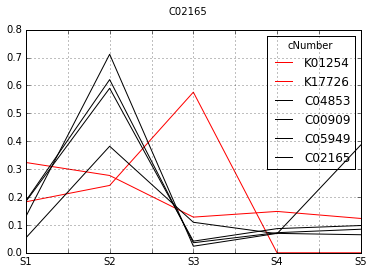

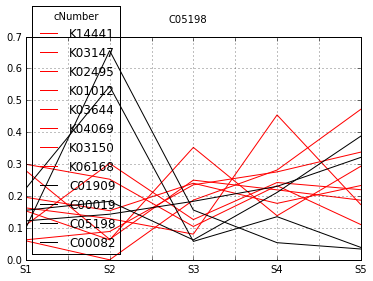

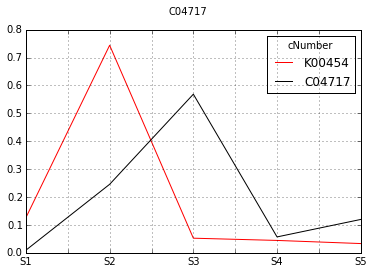

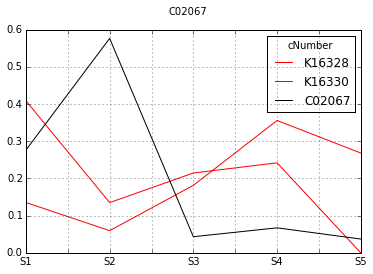

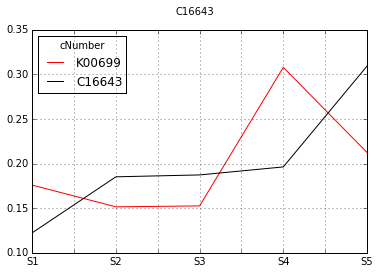

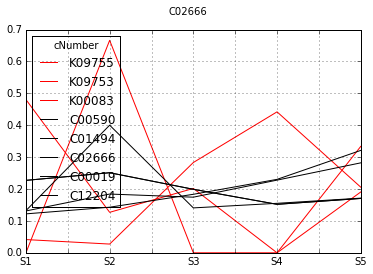

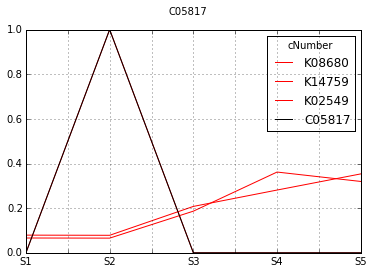

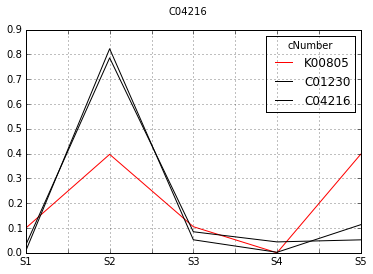

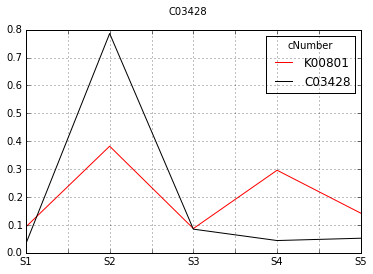

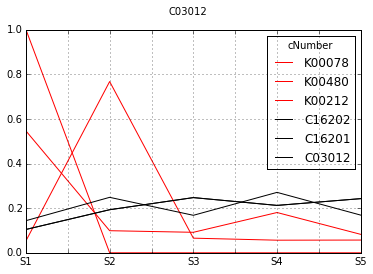

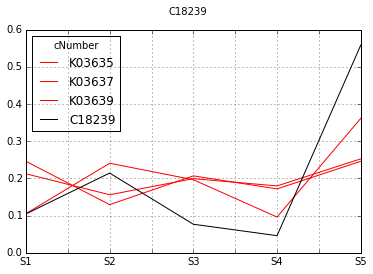

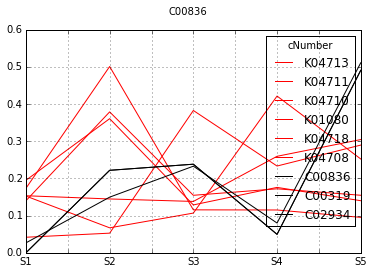

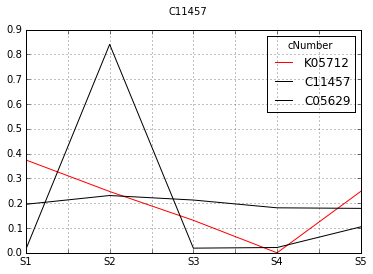

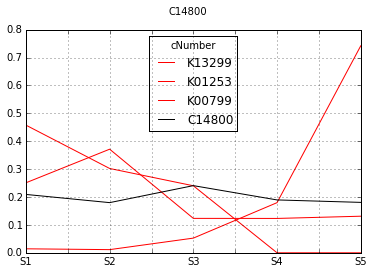

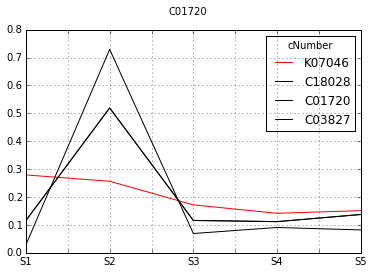

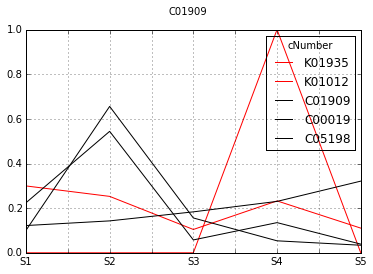

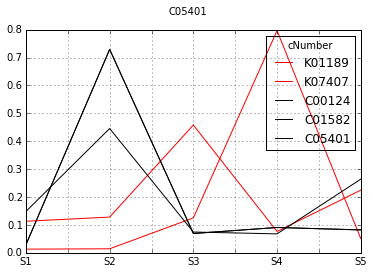

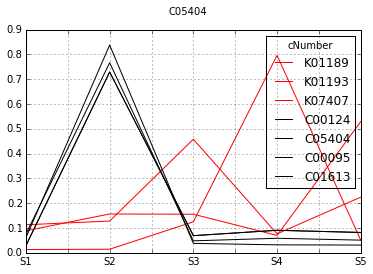

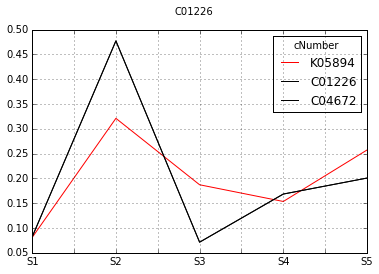

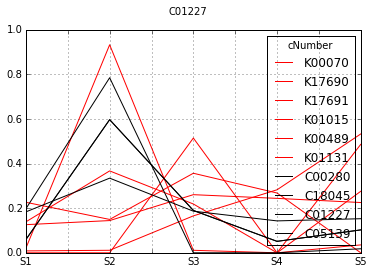

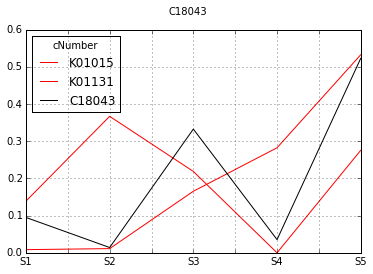

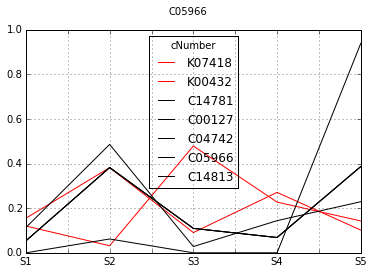

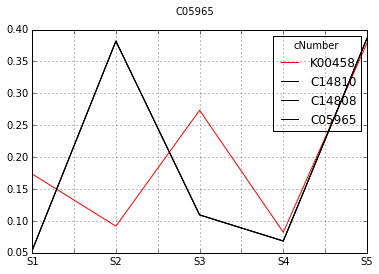

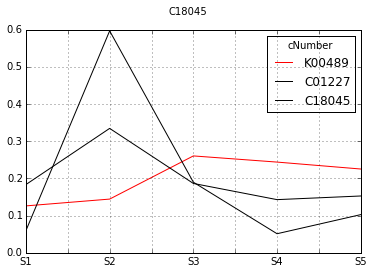

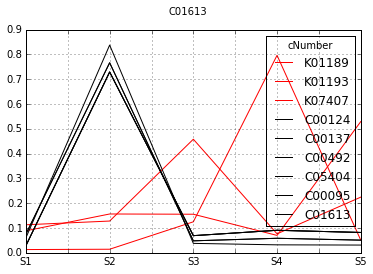

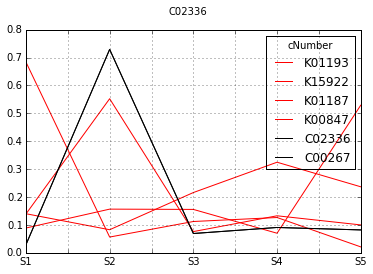

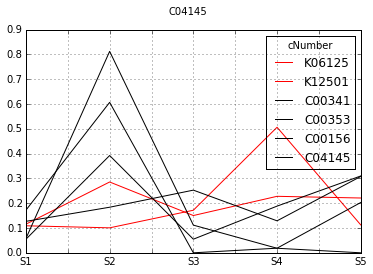

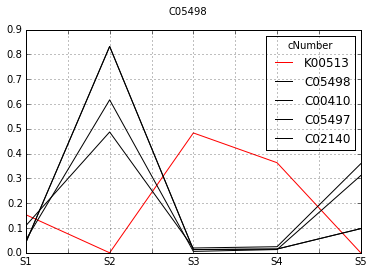

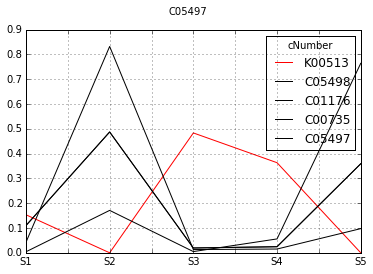

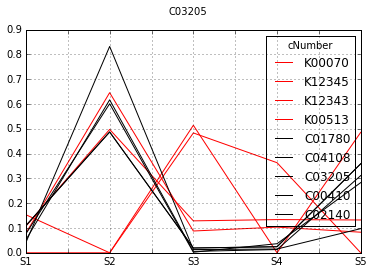

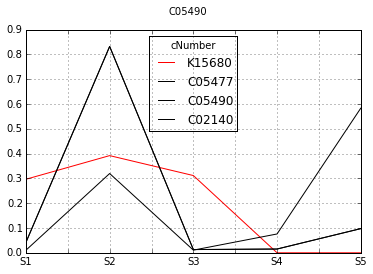

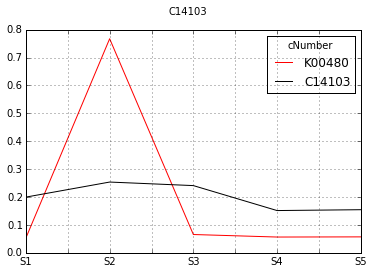

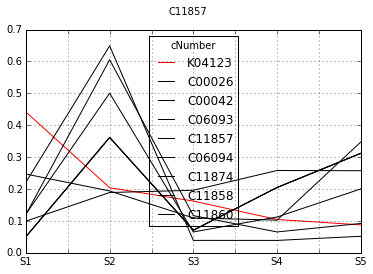

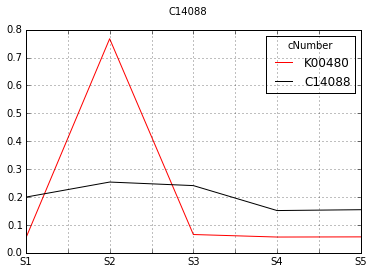

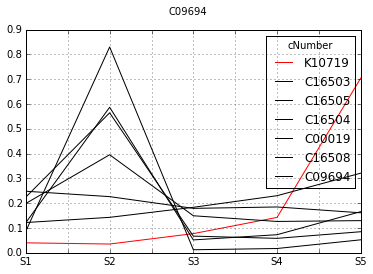

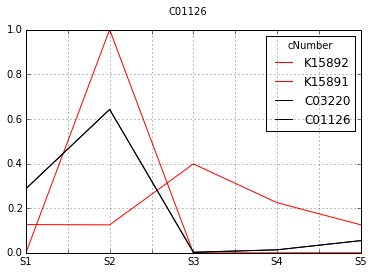

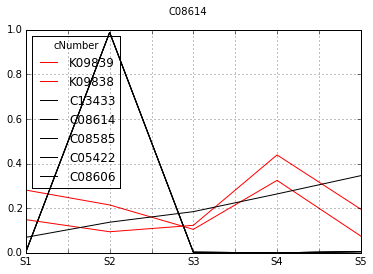

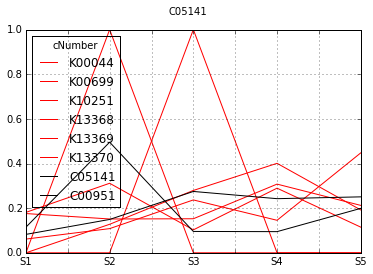

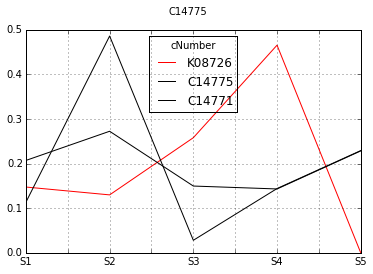

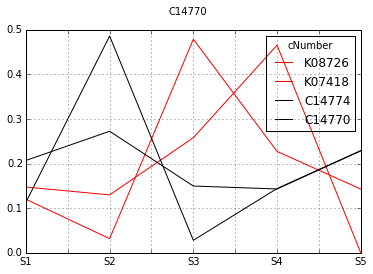

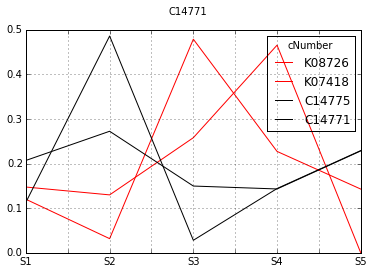

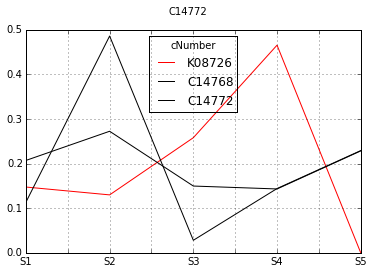

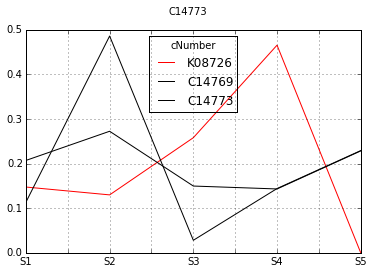

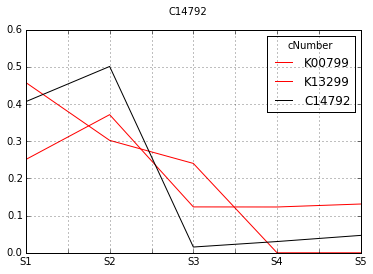

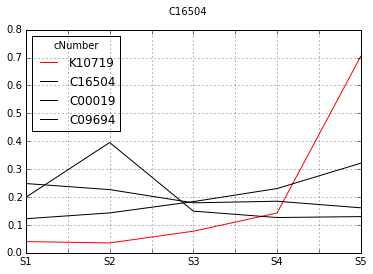

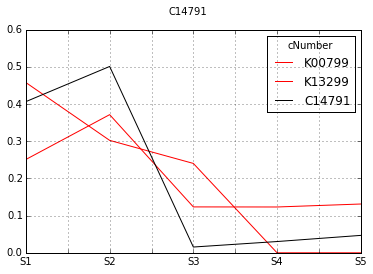

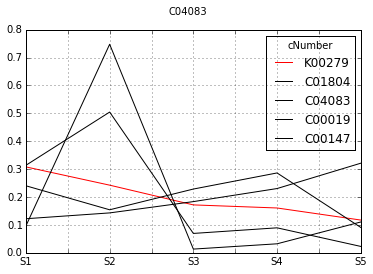

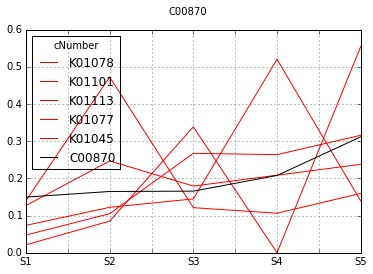

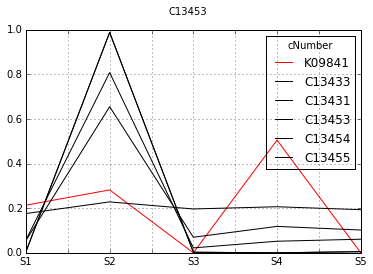

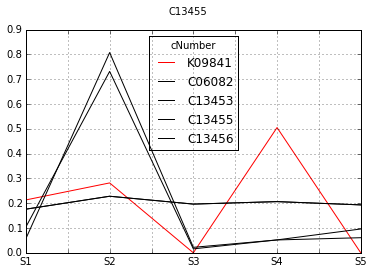

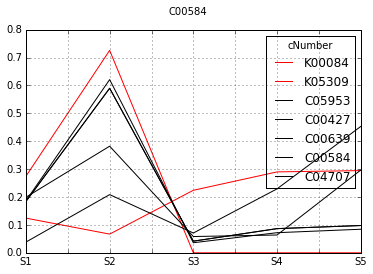

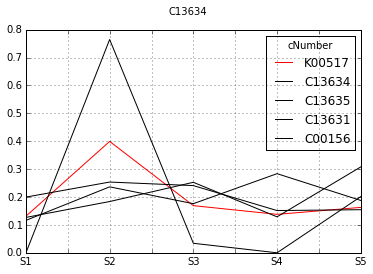

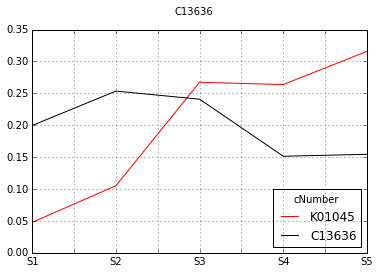

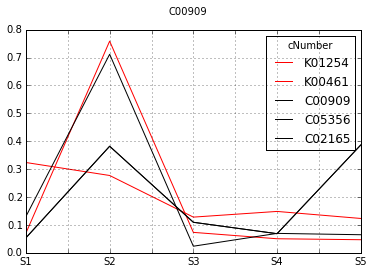

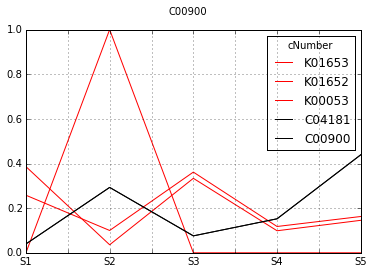

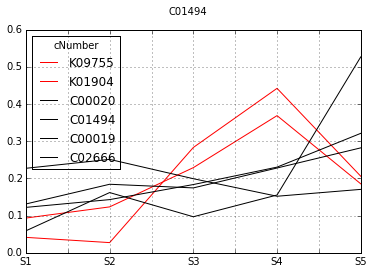

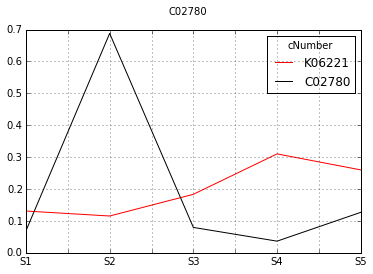

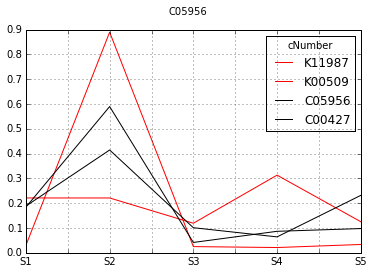

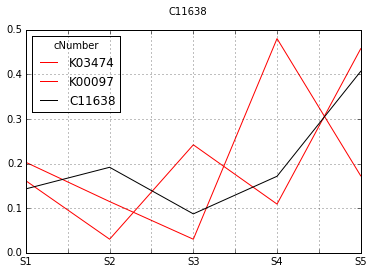

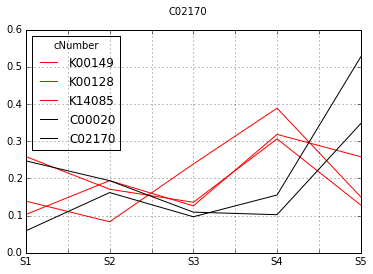

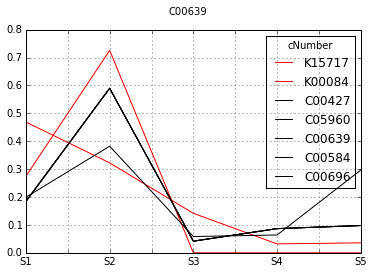

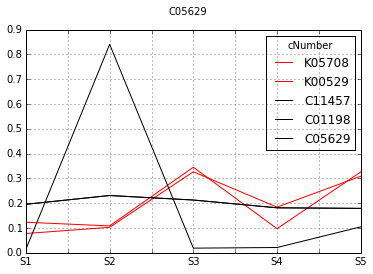

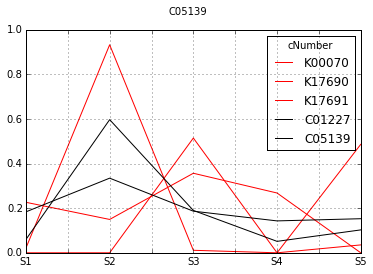

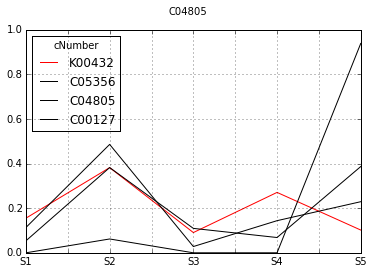

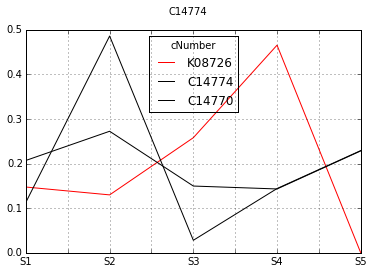

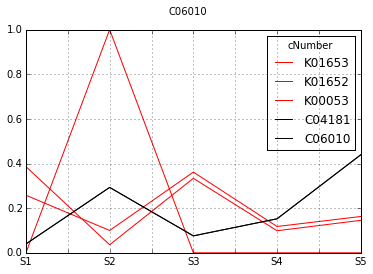

In [645]:
for i, CO in enumerate(CO_withKO):
#     if i==20:
#         break
    kos=CO_withKO[CO]['Related KO']
    cos=CO_withKO[CO]['Related CO']
    for k in kos: 
        if k in KO_RawData.index: 
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            cData=(cData.T/cData.sum(axis=1)).T

            fig, ax=plt.subplots(1)
            kData.T.plot(color='r', ax=ax)
            cData.T.plot(color='k', ax=ax)
            fig.suptitle(CO)
            fig.savefig(CO+'.png')
            break
            